# Base Model

In this notebook, we will build a first model based on VGG16, a model pre-trained on ImageNet. We'll pass the visual information representing the images in our data set through the convolutional layers of this network in order to generate flattened feature vectors out of all images. Given these vectors we can then define metrics to measure 'distances' between two pictures. This finally enables us to apply several clustering algorithms on our image set. 

# Preliminaries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import time
import os, os.path
import random
import cv2
import tensorflow
import keras
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the .csv file
def load_trainCsv():
    df = pd.read_csv('./input/train.csv')    
    return df

df_train = load_trainCsv()
df_train = df_train.sort_values(by="label_group")

In [3]:
# create a new column: matches_true
tmp = df_train.groupby(['label_group'])['posting_id'].unique().to_dict()
df_train['matches_true'] = df_train['label_group'].map(tmp)
df_train['matches_true'] = df_train['matches_true'].apply(lambda x: ' '.join(x))
df_train.head(3)

,posting_id,image,image_phash,title,label_group,matches_true
3874,train_1646767365,1d7aadc7503b2b4539cc9a5fe41979dd.jpg,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,train_1646767365 train_1528423085 train_398181303
31859,train_1528423085,eec692257e74fcbc6cb63cb76d0f20e7.jpg,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047,train_1646767365 train_1528423085 train_398181303
6738,train_398181303,3301b8aaccea93d1098995ffbc537335.jpg,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047,train_1646767365 train_1528423085 train_398181303


## Loading and normalizing images

In [4]:
# Load the images and resize them to 224 x 224. This is the size our pre-trained model prefers.

def load_images(df_train):
    
    folder_name = "./input/shopee-product-matching/train_images"
    images = []
    labels = []
    posting_id = []
    
    for p_id in df_train['posting_id']:       
        img_name = df_train[df_train['posting_id'] == p_id]['image'].values[0]
        img = folder_name + '/' + img_name
    
        if img[-4:] == ".jpg":
            image = cv2.imread(img)
            image = cv2.resize(image, (224,224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Save this visual information in one list (images), save the respective labels in another list (labels) 
            # The same for the posting_ids
            images.append(image)
            label = df_train[df_train["posting_id"] == p_id]["label_group"].values[0]
            labels.append(label)
            posting_id.append(p_id)
            
    return images,labels, posting_id

In [5]:
images,labels,posting_id = load_images(df_train)

We now transform the lists containing the visual information respectively the labels into NumPy arrays. Then we normalize the array containing the visual information. This will facilitate preprocessing them with the VGG16 model. 

In [6]:
def normalise_images(images, labels):

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    # normalize the images array by dividing every component through 255
    images /= 255    
    return images, labels

X_train, y_train = normalise_images(images,labels)

## Load VGG16 model and transform images into feature vectors

We first load the entire VGG16 model (including the fully connected layers). To get a quick overview on what the classifications from VGG16 look like, let's have a look on the first ten images out of our data set.

In [7]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=True, weights="imagenet", input_shape=(224,224,3))
p = vgg16_model.predict(X_train[0:10])

In [8]:
# print out the label groups the first ten images belong to
for i in range(0,10):
    print('posting_id: ', posting_id[i],   '  label group: ', labels[i])

posting_id:  train_1646767365   label group:  258047
posting_id:  train_1528423085   label group:  258047
posting_id:  train_398181303   label group:  258047
posting_id:  train_2865605743   label group:  297977
posting_id:  train_1382500866   label group:  297977
posting_id:  train_2070644662   label group:  645628
posting_id:  train_2149563017   label group:  645628
posting_id:  train_2419208039   label group:  645628
posting_id:  train_318767180   label group:  645628
posting_id:  train_789743463   label group:  645628


In [9]:
# print out the prediction VGG16 makes for these images
decode_predictions(p[0:10][:],top = 2)

[[('n03788365', 'mosquito_net', 0.10819273),
  ('n15075141', 'toilet_tissue', 0.07427242)],
 [('n03788365', 'mosquito_net', 0.14711374),
  ('n15075141', 'toilet_tissue', 0.06362324)],
 [('n03788365', 'mosquito_net', 0.13091399),
  ('n15075141', 'toilet_tissue', 0.06639648)],
 [('n03291819', 'envelope', 0.056172915),
  ('n03788365', 'mosquito_net', 0.04525588)],
 [('n03788365', 'mosquito_net', 0.10130049),
  ('n04209239', 'shower_curtain', 0.058161855)],
 [('n03291819', 'envelope', 0.11349606),
  ('n07248320', 'book_jacket', 0.040203404)],
 [('n03788365', 'mosquito_net', 0.104926676),
  ('n03291819', 'envelope', 0.07137099)],
 [('n03788365', 'mosquito_net', 0.1448797),
  ('n15075141', 'toilet_tissue', 0.0840735)],
 [('n03788365', 'mosquito_net', 0.11199081),
  ('n15075141', 'toilet_tissue', 0.06449302)],
 [('n03788365', 'mosquito_net', 0.09336743),
  ('n15075141', 'toilet_tissue', 0.06524198)]]

We can see that most of the images have been classified as mosquito net. We also see that the probabilities with which our images belong to the respective clusters are quite low. This is not surprising, as this net was trained on completely different images. 

### Transforming the images

As already explained above, we do not want to use VGG16 in order to make classifications on our data set, but to transform images into feature vectors on which we want to apply clustering methods. So the visual information only needs to go through the convolutional layers of VGG16. So what we need to do is to load this net again without the fully connected layers (set include_tod=False for this purpose) and make a 'prediction' which then will be flattened. This way we obtain the feature vectors we desired.

In [10]:
# Load the VGG16 model from keras. Set include_top=False, as we want to build our model on the flattened output
# of the CNN 
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [11]:
def covnet_transform(covnet_model, raw_images):
    pred = covnet_model.predict(raw_images)
    # Flatten the output
    flat = pred.reshape(raw_images.shape[0], -1)    
    return flat

# transforming the images contained in X_train into feature vectors
vgg16_output = covnet_transform(vgg16_model, X_train)

# display the length of these vectors
print("The feature vectore has {} entries".format(vgg16_output.shape[1]))

The feature vectore has 25088 entries


## Dimensionality reduction via PCA

Even though the size of the feature vectors we just created is small compared to the information contained in the original matrices representing the picture (224 x 224 x 3), these vectors are still quite large and would make predictions computationally expensive. In order to decrease computation time, we now apply a principle component analysis on our feature vectors.

In [12]:
def create_fit_PCA(data, n_components=100):
    
    p = PCA(n_components=n_components, random_state=42)
    p.fit(data)    
    return p
    
vgg16_pca = create_fit_PCA(vgg16_output)

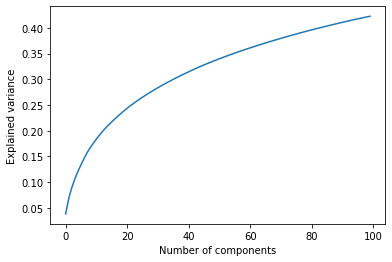

In [13]:
# a plot that displays the variance which is explained by the reduced amount of components
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    plt.show()
    
pca_cumsum_plot(vgg16_pca)

In [14]:
# now apply PCA on the output vectores of our VGG16 model
vgg16_output_pca = vgg16_pca.transform(vgg16_output)

In [15]:
# Create a dictionary which containes the feature vectors (after PCA) to every posting_id
dic_fv = dict(zip(df_train.posting_id.values,list(vgg16_output_pca)))

# Clustering

Based on the feature vectors we've just created via PCA, we now want to apply three clustering algorithms and check out to which extent they are able to find the label groups defined in our data set.

## k-Means

We'll first use a k-Means clustering. When evaluating the results, please be aware that we told the model that the number of clusters should be the actual number of label groups contained in our data set.  

In [16]:
def create_train_kmeans(data, number_of_clusters = len(set(y_train))):       
    k = KMeans(n_clusters=number_of_clusters, n_jobs = -1, random_state=42)
    k.fit(data)    
    return k

K_vgg16_pca = create_train_kmeans(vgg16_output_pca)
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)

In [17]:
# create new columns in the DataFrame
df_train["kmeans_cluster"] = np.array(k_vgg16_pred_pca)
tmp = df_train.groupby(['kmeans_cluster'])['posting_id'].unique().to_dict()
df_train['matches_pred'] = df_train['kmeans_cluster'].map(tmp)
df_train['matches_pred'] = df_train['matches_pred'].apply(lambda x: ' '.join(x))

In [18]:
# define a function to calculate the F1-Score of this prediction made with k-Means
def f1_score_kmeans(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [19]:
df_train["f1_kmeans"] = f1_score_kmeans(df_train.matches_true,df_train.matches_pred)

In [20]:
print('F1-Score k-Means:    ',df_train.f1_kmeans.mean())

F1-Score k-Means:     0.5050584059465884


## Clustering via Euclidean distance

In this section, we'll define clusters by measuring the Euclidean distance between all pairs of images (which are now represented by feature vectors). For that purpose we'll simply define a threshold to determine how close two images have to be in order to be considered as belonging to the same cluster. Then we determine for all pictures separately those neighbours which lie within that threshold. This way we obtain a predicted cluster for every single picture. Unlike the clusters we get from k-Means or from DBSCAN, these clusters are not necessarily disjoint (very probably they are not). This is no problem at all as our target metric, the F1-Score, expects predicted clusters for every image which is then compared to the real cluster this image belongs to.

In [21]:
# This method calculates the Euclidean distance between one feature vector and all the others
def calc_distance(dic,pid):
    s1 = dic[pid]
    dist = list()
    for k in dic.keys():
        s2 = dic[k] 
        d = np.sqrt(np.sum(np.square(s1 - s2)))
        dist.append(d)
    return dist

In [22]:
# Check out the nearest neighbours of one particular image
def check_one_pid(dic_fv,df, pid = "train_3645016213"):
    l = calc_distance(dic_fv, pid)
    l[:10]
    dist_df = pd.DataFrame({"posting_id":df.posting_id.values,
                            "label_group": df.label_group.values,
                            "distance": l,                            
                           })
    dist_df = dist_df.sort_values(by = "distance")
    return dist_df

check_one_pid(dic_fv,df_train)

,posting_id,label_group,distance
10,train_3645016213,645628,0.000000
17389,train_38309879,2152124620,23.705448
16866,train_2649294003,2092158825,23.994318
13611,train_1471123207,1687595158,24.930891
5750,train_3989743853,721559761,24.948362
...,...,...,...
10157,train_4053748246,1226243819,54.435429
15254,train_3691504993,1891360161,54.993553
10152,train_2998702168,1226243819,55.270214
7618,train_4122448751,947423206,55.523033


In [23]:
# Define functions in order to do the evaluation
def pred_cluster_of_pid_cnn(pid, dic_fv, threshold):
    fv1 = dic_fv[pid]
    list_pid = list(dic_fv.keys())
    dist = calc_distance(dic_fv,pid)
    df_out = pd.DataFrame({"posting_id":list_pid, "distance":dist})
    df_out = df_out[df_out["distance"] <= threshold]
    ls = df_out["posting_id"].tolist()
    return set(ls)

def real_cluster_of_pid(pid, df):
    df_red_list = df[df["posting_id"] == pid]["matches_true"].apply(lambda x: x.split()).values[0]
    return set(df_red_list)

def f_score(cl_real_i, cl_pred_i):
    s_pred = set(cl_pred_i)
    s_real = set(cl_real_i)
    s_intsec = s_pred.intersection(s_real)
    return 2*len(s_intsec) / (len(s_pred)+len(s_real))

def eval_f1(l_th, df, dic_fv):
    f1 = [[] for _ in range(len(l_th))]
    for i, th in enumerate(l_th):
        for pi in df.posting_id:
            f1[i].append(f_score(real_cluster_of_pid(pi, df),pred_cluster_of_pid_cnn(pi,dic_fv,th)))
        print("Threshold : {}      F1-Score: {}".format(th, np.sum(f1[i]) / len(f1[i])))
    return f1       

In [24]:
f1 = eval_f1([24],df_train,dic_fv)

Threshold : 24      F1-Score: 0.381011314778529


## Clustering with DBSCAN

Finally we'll do a clustering using the DBSCAN method.

In [25]:
db_scan_model = DBSCAN(
                    eps=0.4,
                    min_samples=2,
                    metric='euclidean',
                    metric_params=None,
                    algorithm='auto',
                    leaf_size=30,
                    p=None,
                    n_jobs=None,
                )

In [26]:
db_pred = db_scan_model.fit_predict(list(dic_fv.values()))
print('Number of clusters:   ',len(set(db_pred)))

Number of clusters:    1618


In [27]:
df_train["db_scan"] = db_pred
tmp = df_train.groupby(['db_scan'])['posting_id'].unique().to_dict()
if -1 in tmp.keys(): 
    del tmp[-1]
df_train["db_scan"] = [x if df_train[df_train["posting_id"] == x]["db_scan"].values[0] == -1 else tmp[df_train[df_train["posting_id"] == x]["db_scan"].values[0]] for x in df_train.posting_id ]

In [28]:
def f1_score(y_true, y_pred):
    y_true = y_true.split()
    intersection = np.intersect1d(y_true,y_pred)
    intersection = len(intersection)
    len_y_pred = len(y_pred)
    len_y_true = len(y_true)
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [29]:
f1_db_scan = []
for y_true, y_pred in zip(df_train.matches_true.values, df_train.db_scan.values):
    f1_db_scan.append(f1_score(y_true, y_pred))

In [30]:
# Print out the final F1-Score
print('F1-Score DBSCAN:   ',np.sum(f1_db_scan)/len(f1_db_scan))

F1-Score DBSCAN:    0.1618436010315891


## Future work

We saw that the F1-Score we got from the k-Means clustering was not too bad, but still there is plenty of room for improvement. As the VGG16 model was trained on images which are quite different from those contained in our data set, we did not expect perfect results anyway. Future work on this approach could be a transfer learning model: Instead of simply clustering the feature vectors we got from the convolutional layers of the VGG16 model, we could use these vectors as the input data for a new neural network. This network would then be trained to recognize the specific objects displayed on the images contained in our data set. As the feature vectors we would get from such a method would be much better adapted to the objects we want to cluster, this gives cause to hope to achieve better results that way.